In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
import numpy as np

import random
import os
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from imagenet.imagenet_labels import imagenet_labels_dict
from shearletx import ShearletX
from waveletx import WaveletX
from cartoonx import CartoonX
from smoothmask import SmoothMask

plt.rcParams["font.family"] = "Times New Roman"

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

/home/groups/ai/kolek/miniconda3/envs/scat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Images

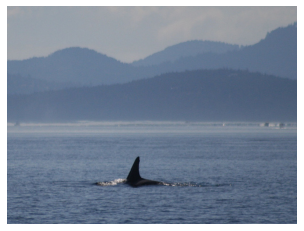

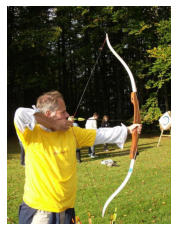

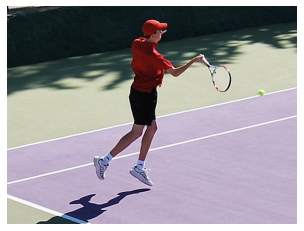

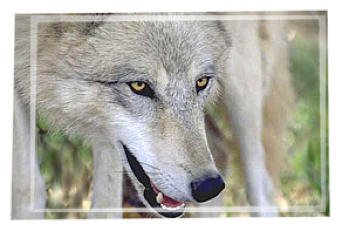

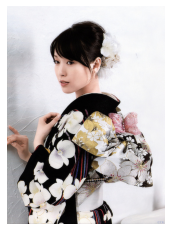

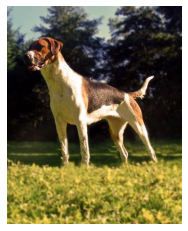

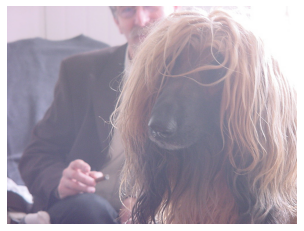

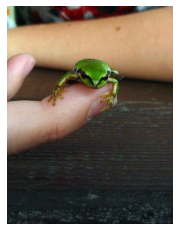

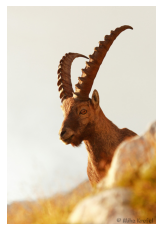

In [5]:
image_tensor_list = []
convert_to_tensor = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(size=(256,256))]
)
    
for file in os.listdir('imgs'):
    # Load the image using the imread() function from matplotlib.image
    img = Image.open(os.path.join('imgs', file)).convert('RGB')
    # Plot the image using imshow() function from pyplot
    plt.imshow(img)
    plt.axis('off')
    # Show the plot
    plt.show()
    image_tensor_list.append(convert_to_tensor(img).unsqueeze(0))

### Load Model 
We first compute explanation masks for the [MobilenetV3](https://arxiv.org/pdf/1905.02244v5.pdf) model on verious images.

In [6]:
# Get device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Define input normalization layer for imagenet images
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean, device=device, requires_grad=False)
        self.std = torch.tensor(std, device=device, requires_grad=False)

    def forward(self, x):
        x = x - self.mean.reshape(self.mean.size(0),1,1)
        x = x / self.std.reshape(self.std.size(0),1,1)
        return x

# Get model
network = models.vgg19(pretrained=True).eval().to(device)
# Add input normalization layer
model = nn.Sequential(Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), network)

### ShearletX
<u>Hyperparameters:</u> 
- `l1lambda` = multiplier for l1 norm of shearlet mask
- `lr` = learning rate for optimization of shearlet mask
- `obfuscation` = noise perturbation distribution for mask ['uniform', 'gaussian']
- `optim_steps` = number of steps that optimize the mask
- `noise_bs` = batch size for noise perturbations
- `l1_reg` = multiplier for l1 spatial (pixelspace) regularization
- `mask_init` = initial mask (works best with all ones as initial mask)

Iter 149/150
Time: 48.35


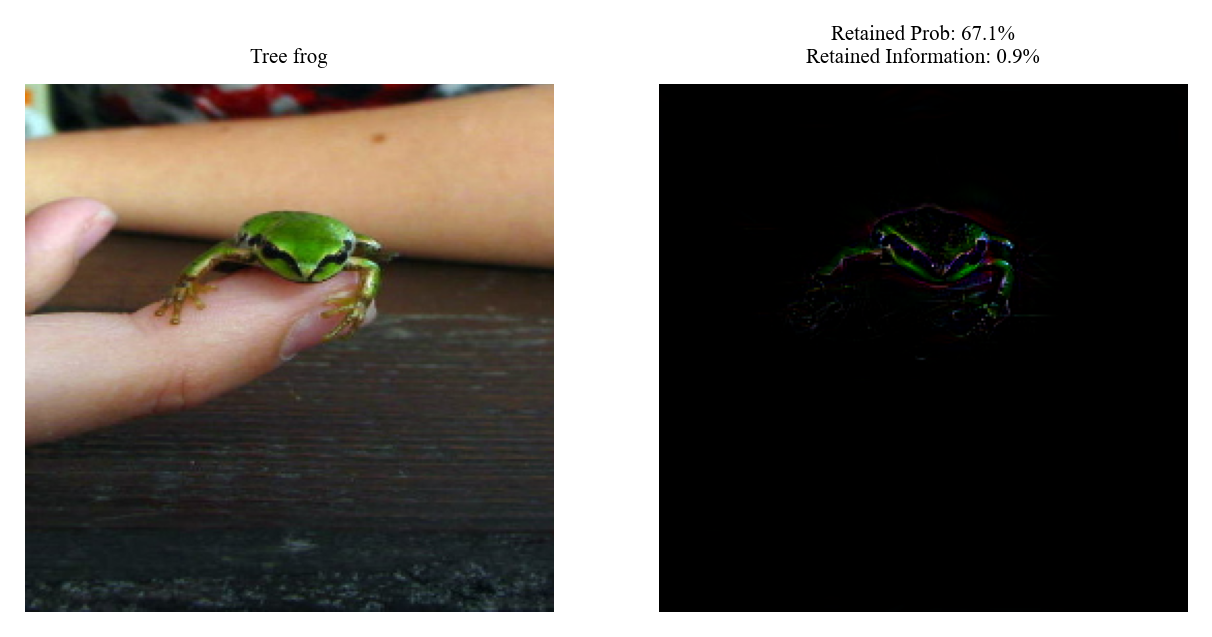

In [7]:
idx = 7
x = image_tensor_list[idx].to(device)
    
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Hparams ShearletX with spatial reg
SHEARLETX_HPARAMS = {
    "l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'l1_reg': 35., 'mask_init': 'ones'
} 

# ============================== Compute ShearletX ===============================
t = time.time()
shearletx_method = ShearletX(model=model, device=device, **SHEARLETX_HPARAMS)
shearletx, history_shearletx = shearletx_method(x, preds)
shearletx = shearletx/shearletx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# ShearletX Visualization
axs[1].imshow(shearletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(shearletx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = shearletx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%', fontsize=s)
plt.show()

### WaveletX
<u>Hyperparameters:</u> 
- `l1lambda` = multiplier for l1 norm of wavelet mask
- `lr` = learning rate for optimization of wavelet mask
- `obfuscation` = noise perturbation distribution for mask ['uniform', 'gaussian']
- `optim_steps` = number of steps that optimize the mask
- `noise_bs` = batch size for noise perturbations
- `l1_reg` = multiplier for l1 spatial (pixelspace) regularization
- `mask_init` = initial mask (works best with all ones as initial mask)

Iter 149/150
Time: 19.09


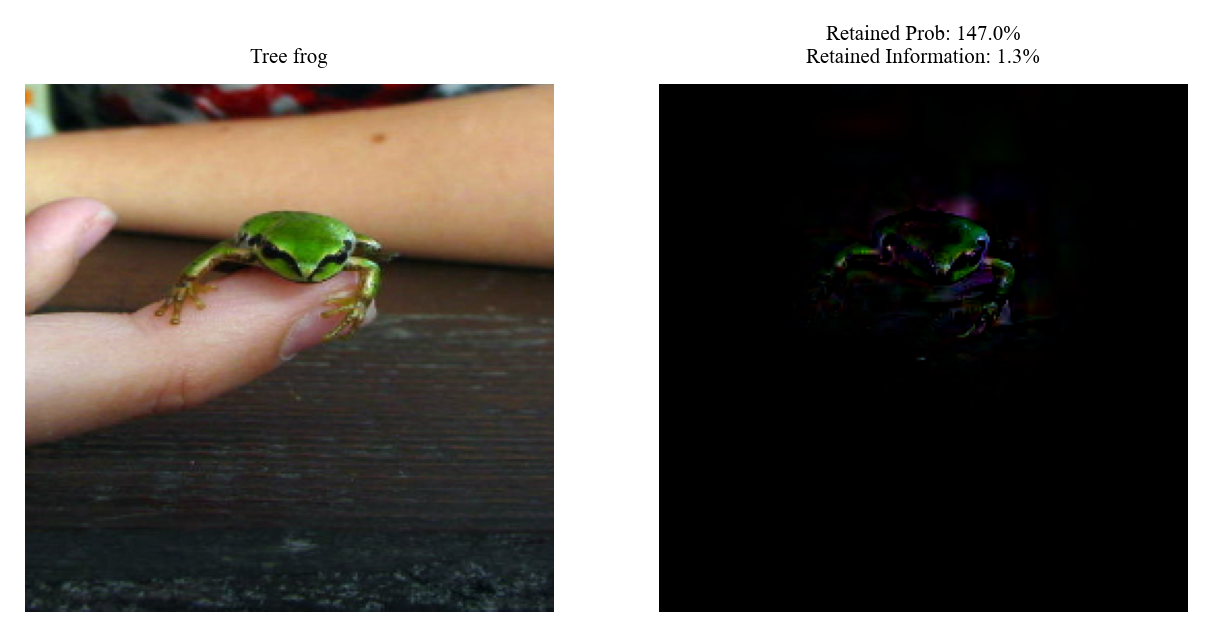

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
idx = 7
x = image_tensor_list[idx].to(device)

# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Hparams WaveletX with spatial reg
WAVELETX_HPARAMS = {
    "l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'l1_reg': 35., 'mask_init': 'ones'
} 

# ============================== Compute WaveletX ===============================
t = time.time()
waveletx_method = WaveletX(model=model, device=device, **WAVELETX_HPARAMS)
waveletx, history_waveletx = waveletx_method(x, preds)
waveletx = waveletx/waveletx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# WaveletX Visualization
axs[1].imshow(waveletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(waveletx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = waveletx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%', fontsize=s)
plt.show()

### CartoonX
*Note that [CartoonX](https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136720439.pdf) is WaveletX with zero spatial regularization.*

<u>Hyperparameters:</u> 
- `l1lambda` = multiplier for l1 norm of wavelet mask
- `lr` = learning rate for optimization of wavelet mask
- `obfuscation` = noise perturbation distribution for mask ['uniform', 'gaussian']
- `optim_steps` = number of steps that optimize the mask
- `noise_bs` = batch size for noise perturbations
- `mask_init` = initial mask (works best with all ones as initial mask)

Iter 149/150
Time: 18.98


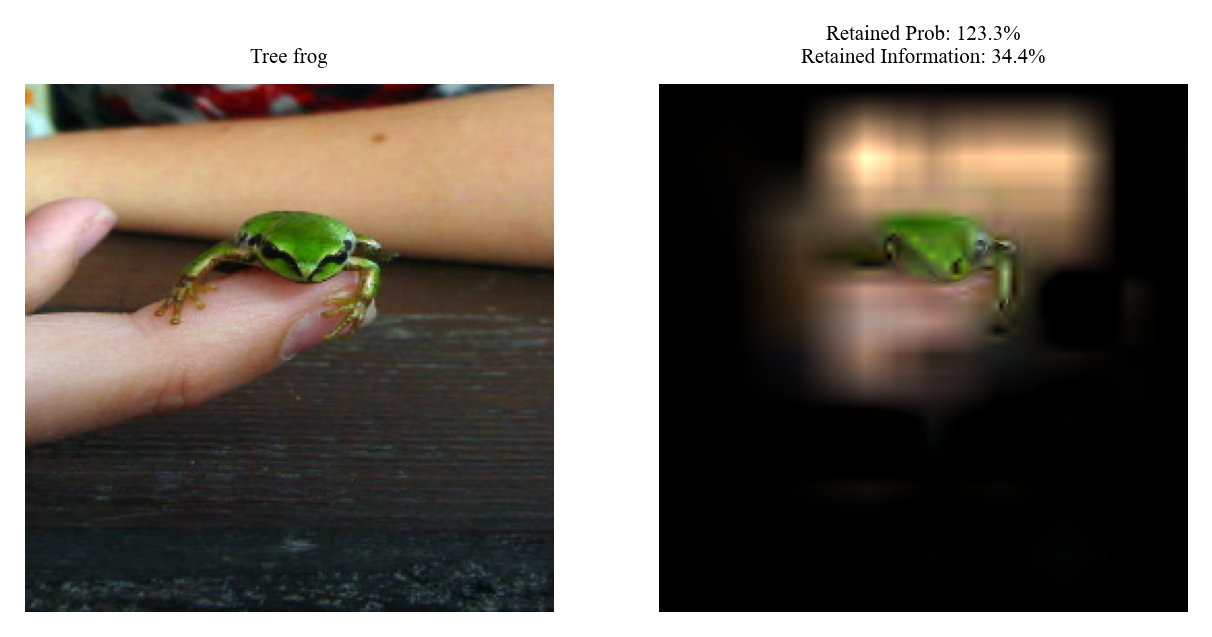

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
idx = 7
x = image_tensor_list[idx].to(device)
    
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Hparams WaveletX with spatial reg
CARTOONX_HPARAMS = {
    "l1lambda": 155., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'mask_init': 'ones'
} 

# ============================== Compute CartoonX ===============================
t = time.time()
cartoonx_method = CartoonX(model=model, device=device, **CARTOONX_HPARAMS)
cartoonx, history_cartoonx = cartoonx_method(x, preds)
cartoonx = cartoonx/cartoonx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# CartoonX Visualization
axs[1].imshow(cartoonx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(cartoonx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = cartoonx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%', fontsize=s)
plt.show()

### Smooth Pixelmask
In our paper we, refer to the [extremal perturbation method](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/fong19understanding.pdf) by Fong et al. as <u>smooth pixel mask explanations</u> to highlight the fact that the method essentially optimizes a smooth explanation mask on the image pixels.

<u>Hyperparameters:</u>
- `area` = fraction of image area that the smoothmask keeps

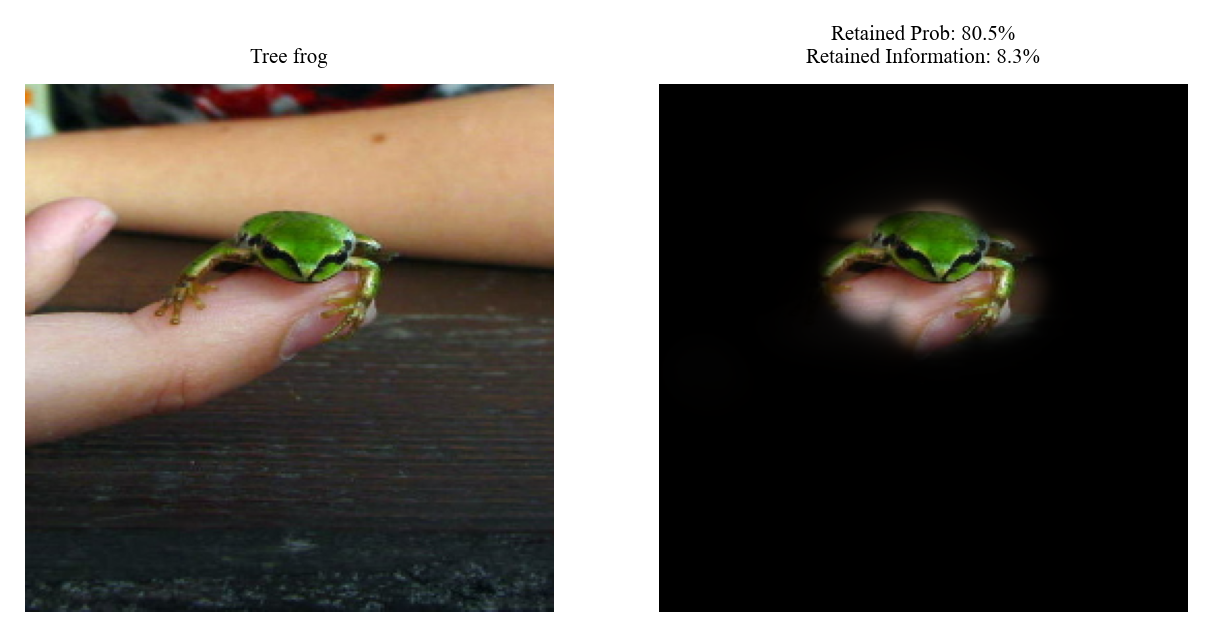

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
idx = 7
x = image_tensor_list[idx].to(device)
    
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()


# ============================== Compute Smoothmask ==============================
area = 0.05 # How much area should be kept by smoothmask
smoothmask_method = SmoothMask(area, model)
smoothmask = smoothmask_method(x, preds[0].item())

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')
# Smoothmask Visualization
axs[1].imshow(smoothmask.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(smoothmask)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = smoothmask.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%', fontsize=s)
plt.show()

### GradCAM

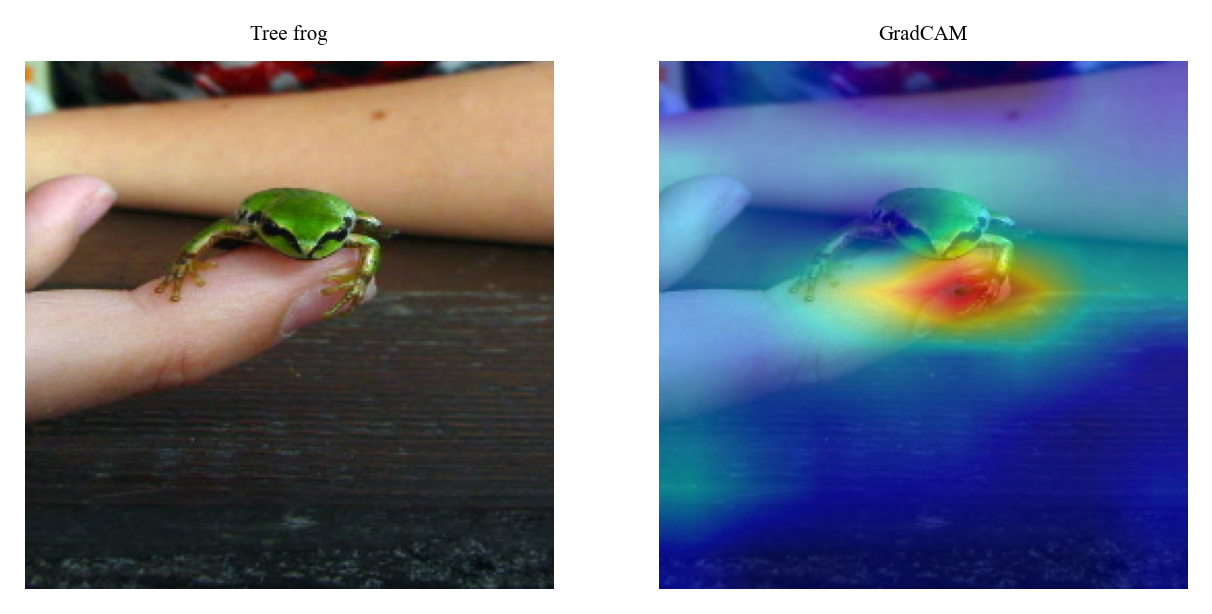

In [11]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
idx = 7
x = image_tensor_list[idx].to(device)
    
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# ============================== Compute GradCAM ==============================
target_layer = '[1].features[-1]'
target_layers = [eval('model'+target_layer)]
targets = None
# Need paramters to require grad to compute gradcam
for param in model.parameters():
    param.requires_grad = True

# Construct the GradCAM object
gradcam_method = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = gradcam_method(input_tensor=x, targets=targets)
grayscale_cam = (grayscale_cam / grayscale_cam.max())

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
img = x.detach().squeeze(0).permute(1,2,0).cpu().numpy()
gradcam = torch.tensor(show_cam_on_image(img, grayscale_cam, use_rgb=True))

# Set grad to false now that gradcam is computed
for param in model.parameters():
    param.requires_grad = False

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')
# GradCAM Visualization
axs[1].imshow(gradcam.squeeze(0).cpu())
axs[1].axis('off')
axs[1].set_title('GradCAM', fontsize=s)
plt.show()


In [41]:
idx = 6
x = image_tensor_list[idx].to(device)
    
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Hparams ShearletX with spatial reg
SHEARLETX_HPARAMS = {
    "l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform',
    "maximize_label": True, "optim_steps": 150,  
    "noise_bs": 16, 'l1_reg': 3., 'mask_init': 'ones'
} 

# ============================== Compute ShearletX ===============================
t = time.time()
shearletx_method = ShearletX(model=model, device=device, **SHEARLETX_HPARAMS)
shearletx, history_shearletx = shearletx_method(x, preds)
shearletx = shearletx/shearletx.max()
print(f'\nTime: {time.time()-t:.2f}')

# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,2, dpi=250)
s = 6 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# ShearletX Visualization
axs[1].imshow(shearletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
fidelity = nn.Softmax(dim=-1)(model(shearletx)).max(1)[0].item()
acc = nn.Softmax(dim=-1)(model(x)).max(1)[0].item()
retained_prob = fidelity / acc
retained_information = shearletx.abs().sum() / x.abs().sum()
axs[1].set_title(f'Retained Prob: {(100*retained_prob):.1f}%\nRetained Information: {(100*retained_information):.1f}%', fontsize=s)
plt.show()

ValueError: could not broadcast input array from shape (1,6) into shape (1,7)